# Vision Transformer from scratch

In [8]:
import numpy as np
from tqdm import tqdm_notebook, trange
import matplotlib.pyplot as plt

import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim
import mlx.data as dx
from mlx.data.datasets import load_mnist

In [10]:
np.random.seed(0)
mx.random.seed(0)

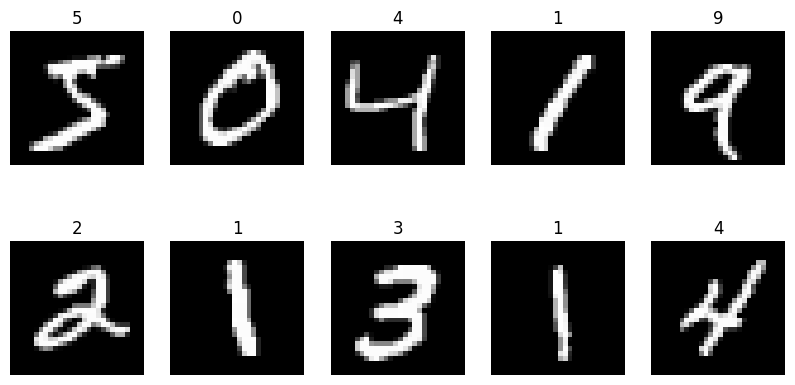

In [19]:
# Load the MNIST dataset
mnist_train_data = load_mnist("./Data/Train", train=True)
mnist_test_data = load_mnist("./Data/Test", train=False)
train_loader = (
    mnist_train_data.shuffle()
    .to_stream()
    .key_transform("image", lambda x: x.astype("float32") / 255.0)
    .batch(128)
)
test_loader = (
    mnist_test_data.to_stream()
    .key_transform("image", lambda x: x.astype("float32") / 255.0)
    .batch(128)
)

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(mnist_train_data[i]["image"], cmap="gray")
    plt.title(mnist_train_data[i]["label"])
    plt.axis("off")

## Patchfitying the input image

In [29]:
@mx.compile
def patchify(images, n_patches):
    n, h, w, c = images.shape

    assert h == w, "Patchifying is currently only supported for square images"

    patches = mx.zeros((n, n_patches**2, h * w * c // n_patches**2))
    patch_size = h // n_patches

    for idx, image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[
                    i * patch_size : (i + 1) * patch_size,
                    j * patch_size : (j + 1) * patch_size,
                ]
                patches[idx, i * n_patches + j] = patch.reshape(-1)
    return patches

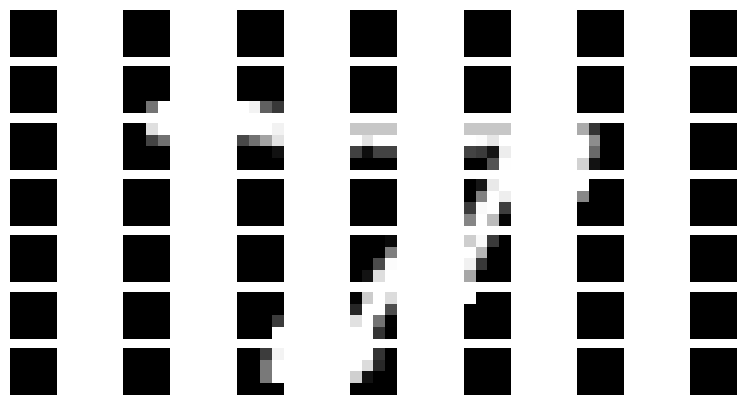

In [33]:
# Testing patchify on a single test image
test_image = mx.array(mnist_test_data[0]["image"])
test_patches = patchify(test_image[None, ...], 7)
plt.figure(figsize=(10, 5))
for i in range(49):
    plt.subplot(7, 7, i + 1)
    plt.imshow(test_patches[0, i].reshape(4, 4), cmap="gray")
    plt.axis("off")


In [34]:
test_patches.shape

(1, 49, 16)

In [22]:
class MyViT(nn.Module):
    def __init__(self, hwc=(28, 28, 1), n_patches=7, hidden_dim=64):
        super().__init__()

        self.hwc = hwc
        self.n_patches = n_patches

        assert hwc[0] % n_patches == 0, "Image height must be divisible by n_patches"
        assert hwc[1] % n_patches == 0, "Image width must be divisible by n_patches"

        self.patch_size = (hwc[0] // n_patches, hwc[1] // n_patches)

        # 1. Linear mapping
        self.hidden_dim = hidden_dim
        self.input_d = int(hwc[2] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_dim)

        # 2. Add learnable classification token
        self.cls_token = nn.Parameter((1, 1, self.hidden_dim))

    def __call__(self, images):
        patches = patchify(images, self.n_patches)
        tokens = self.linear_mapper(patches)
        tokens = mx.stack([self.cls_token] + tokens, axis=1)
        return patches